#### import needed libraries

In [2]:
import ROOT
import numpy as np
import root_numpy as rnp
import pandas as pd
import matplotlib.pyplot as plt

#### define filenames 

In [3]:
detfile = "utilities/km3net_jul13_90m.detx"
nuefile = "utilities/km3_v4_nuecc_1.evt.JTE.aa.root"
numufile = "utilities/km3_v4_numucc_1_B.evt.aa.root"

#### import trees from root files using rnp

In [4]:
from load_trees import load_trees

In [6]:
ch_id_numu, dom_id_numu, trig_numu, times_numu = load_trees(numufile)
ch_id_nue, dom_id_nue, trig_nue, times_nue = load_trees(nuefile)

#### save doms and pmts positions from detector file

In [7]:
from detector_positions import structured_positions

In [8]:
doms, pmts = structured_positions(detfile)

#### define lattice and save lattice points and lattice_doms positions to np ndarray

- lattice: positions of the points of the regular lattice
- l_doms: positions of the 2070 doms in the regular lattice

from lattice_doms_znew import lattice_doms

lattice, l_doms = lattice_doms(detfile)

#### create a map to link dom ids to lattice point ids
indices: ndarray
contains ids of the lattice points which correspond to doms

In [47]:
indices = []
for i, (x,y,z) in enumerate(lattice):
    for j,(xd,yd,zd) in enumerate(l_doms):
        if (x,y,z)==(xd,yd,zd):
            #print(i)
            indices.append((i, j))
indices = np.asarray(indices)

In [48]:
doms_map = np.sort(indices, axis=1)[:,0] #this array has 2070 elements, each corresponding to a dom

In [49]:
doms_map.shape

(2070,)

In [50]:
doms_map[:10]

array([324, 325, 326, 327, 328, 329, 330, 331, 332, 333])

#### totally crazy and inefficient way to create an array of indices for the lattice XD 

In [51]:
i=[]
j=[]
k=[]
for ii,x in enumerate(range(-300,1100,90)):
    for jj,y in enumerate(np.arange(-550,550, 45*np.sqrt(3))):
        for kk,z in enumerate(range(98,712,36)):
            i.append(ii)
            j.append(jj)
            k.append(kk)
        x-= 45
l_i = np.asarray(i)
l_j = np.asarray(j)
l_k = np.asarray(k)

In [52]:
l_i.shape

(4320,)

In [53]:
arr = []
for i,j,k in zip(l_i,l_j,l_k):
    arr.append((i,j,k))
lol = np.asarray(arr)

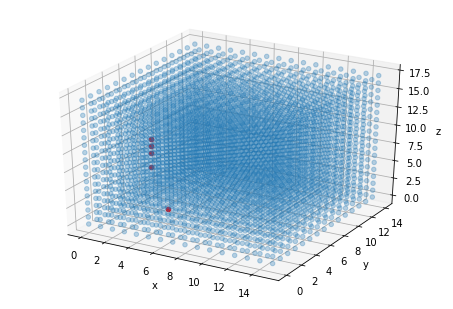

In [77]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(l_i, l_j, l_k , alpha=0.3)
ax.scatter(4, 4,1, color='red')
ax.scatter(0, 8, 5, color='red')
ax.scatter(0, 8, 3, color='red')
ax.scatter(0, 8, 6, color='red')
ax.scatter(0, 8, 7, color='red') 
#ax.scatter(doms["x"], doms["y"], doms["z"], color="green", alpha=0.9)
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

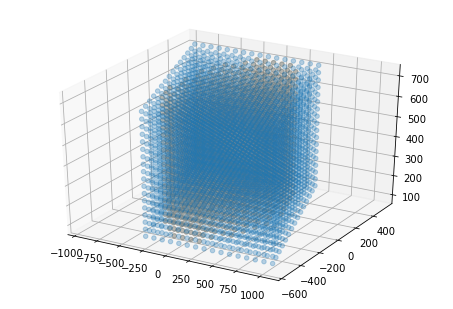

In [55]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(lattice["x"], lattice["y"], lattice["z"], alpha=0.3)
ax.scatter(l_doms["x"], l_doms["y"], l_doms["z"], alpha=0.3)

#ax.scatter(doms["x"], doms["y"], doms["z"], color="green", alpha=0.9)
ax.grid()

plt.show()

In [56]:
print(np.max(l_i), np.max(l_j),np.max(l_k)) 
print(np.min(l_i), np.min(l_j),np.min(l_k)) 

(15, 14, 17)
(0, 0, 0)


In [57]:
16*18*15

4320

In [58]:
lol

array([[ 0,  0,  0],
       [ 0,  0,  1],
       [ 0,  0,  2],
       ..., 
       [15, 14, 15],
       [15, 14, 16],
       [15, 14, 17]])

In [59]:
ret = np.zeros((16,15,18))

In [32]:
ret.shape

(16, 15, 18)

#### timeslice definition (given the input files)

In [60]:
from timeslices import tslices

In [61]:
tslice = tslices(times_numu, times_nue)

(49997887.0, 49993098.0, 50000747.0, 50004225.0, 49993098.0, 50004225.0)


#### tentative definition of X:
X should have, for each t, (i,j,k) <- indices of the i-th point, h: number of hits in the timeslice in the dom (dom_hit_in_slice)

In [76]:
numu_events = dom_id_numu.shape[0]
n_timeslices = tslice.shape[0] - 1
#X = np.zeros((numu_events,n_timeslices, ret.shape))
X = np.zeros((numu_events,n_timeslices, ret.shape[0],ret.shape[1],ret.shape[2]))
for evt in range(numu_events):
    triggered_dom_ids = (dom_id_numu[evt][trig_numu[evt] == True]) - 1
    times_event_hits = times_numu[evt]
    for ts, tsl in enumerate(zip(tslice[:-1], tslice[1:])):
            low, high = tsl
            hits = np.where((times_event_hits >= low) & (times_event_hits < high))[0]
            if not len(hits):
                continue
            #print(low,high, hits)
            dom_hit_in_slice = triggered_dom_ids[hits]
            l_dom_hit_in_slice = doms_map[dom_hit_in_slice]
            l_ret = lol[l_dom_hit_in_slice]
            for dom_indx in l_ret:
                #print(evt, ts, dom_indx[0],dom_indx[1],dom_indx[2])
                X[evt, ts, dom_indx[0],dom_indx[1],dom_indx[2]] +=1
            #print("dom_hit_in_slice: ",dom_hit_in_slice)
            #print("l_dom_hit_in_slice: ",l_dom_hit_in_slice)
            #print(evt, ts, l_ret)
            #print(l_dom_hit_in_slice)# , dom_hit_in_slice)
            
            #X[evt, ts, l_ret[0],l_ret[1],l_ret[2]] +=1
            #print(X[evt, ts, l_ret])


In [250]:
X.shape

(1541, 75, 16, 15, 19)

In [ ]:
# %load data_preparation
import numpy as np

NFLOORS = 18
NSTRING = 115
PMTSPERDOM = 31
pmtstot = NFLOORS * NSTRING * PMTSPERDOM
ndoms = NFLOORS * NSTRING

#this function creates X with dimension (nevents, timeslice.shape, 2070)
def Xy_creation(timeslices, dom_id, trig, times, flag):
    numu_events = dom_id.shape[0]
    n_timeslices = timeslices.shape[0] - 1

    X_nu = np.zeros((numu_events, n_timeslices, ndoms))

    for evt in range(numu_events):
        # Get all DOM ids for all triggered hits in current event
        triggered_dom_ids = (dom_id[evt][trig[evt] == True]) - 1
        #print("triggered_dom_ids", triggered_dom_ids)
        times_event_hits = times[evt] # select only hits for current event 
        #print("times_event_hits", times_event_hits, times_event_hits.shape[0])
        
        for ts, tslice in enumerate(zip(timeslices[:-1], timeslices[1:])):
            low, high = tslice
            #print(ts, "low", low, "high", high)
            # hits will hold indices of hits matching the condition of being in the selected timeslice
            hits = np.where((times_event_hits >= low) & (times_event_hits < high))[0] 
            #print('hits: ', hits)
            #continue
            if not len(hits):
                continue

            # Get all DOM ids associated to all hits in current time slice.
            dom_hit_in_slice = triggered_dom_ids[hits]
            #print("doms_hit_in_slice", dom_hit_in_slice)
            #print("hits", hits)
            #print(hits.shape)
            # Activate all DOMs for current event, timeslice.
            X_nu[evt, ts, dom_hit_in_slice] = 1
    if flag=='numu':        
        Y_nu = np.ones(dom_id.shape[0])
    elif flag=='nue':
        Y_nu = np.zeros(dom_id.shape[0])
    return X_nu, Y_nu

In [15]:
lattice

array([(-300., -550.        ,  100.), (-300., -550.        ,  134.),
       (-300., -550.        ,  168.), ..., ( 420.,  541.19200877,  644.),
       ( 420.,  541.19200877,  678.), ( 420.,  541.19200877,  712.)],
      dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8')])

In [14]:
eff = np.zeros(lattice.shape[0])
eff[indices[:,0]]=1
#eff[~indices[:,0]]=0

In [ ]:
for pt in lattice:
    

In [12]:
dm = pd.DataFrame({"doms_pos":doms, "lattice_d_pos":l_doms})

In [16]:
latt_df = pd.DataFrame({"lattice_x":lattice["x"], "lattice_y":lattice["y"], "lattice_z":lattice["z"], "eff":eff, 
                     "i":i, "j":j, "k":k, "hits":0})

In [157]:
latt_mat = latt_df.as_matrix()

In [18]:
latt_doms=latt_df.loc[latt_df["eff"]==1]

In [19]:
mat_doms = latt_doms.as_matrix()

In [24]:
mat_doms

array([[   1.        ,    0.        ,    1.        , ..., -345.        ,
        -316.17314098,  100.        ],
       [   1.        ,    0.        ,    1.        , ..., -345.        ,
        -316.17314098,  134.        ],
       [   1.        ,    0.        ,    1.        , ..., -345.        ,
        -316.17314098,  168.        ],
       ..., 
       [   1.        ,    0.        ,   13.        , ...,  330.        ,
         385.30743609,  644.        ],
       [   1.        ,    0.        ,   13.        , ...,  330.        ,
         385.30743609,  678.        ],
       [   1.        ,    0.        ,   13.        , ...,  330.        ,
         385.30743609,  712.        ]])

In [192]:
mat_doms[:,1][dom_id_numu[0][trig_numu[0]==1]]=1

In [193]:
np.where(mat_doms[:,1]==1)

(array([1397, 1398, 1399, 1401, 1907]),)

In [17]:
latt_df.loc[latt_df["eff"]==1]

,eff,hits,i,j,k,lattice_x,lattice_y,lattice_z
342,1.0,0,1,3,0,-345.0,-316.173141,100.0
343,1.0,0,1,3,1,-345.0,-316.173141,134.0
344,1.0,0,1,3,2,-345.0,-316.173141,168.0
345,1.0,0,1,3,3,-345.0,-316.173141,202.0
346,1.0,0,1,3,4,-345.0,-316.173141,236.0
347,1.0,0,1,3,5,-345.0,-316.173141,270.0
348,1.0,0,1,3,6,-345.0,-316.173141,304.0
349,1.0,0,1,3,7,-345.0,-316.173141,338.0
350,1.0,0,1,3,8,-345.0,-316.173141,372.0
352,1.0,0,1,3,10,-345.0,-316.173141,440.0


In [98]:
dd = l_doms[~np.unique(l_doms, return_index=True)[1]]

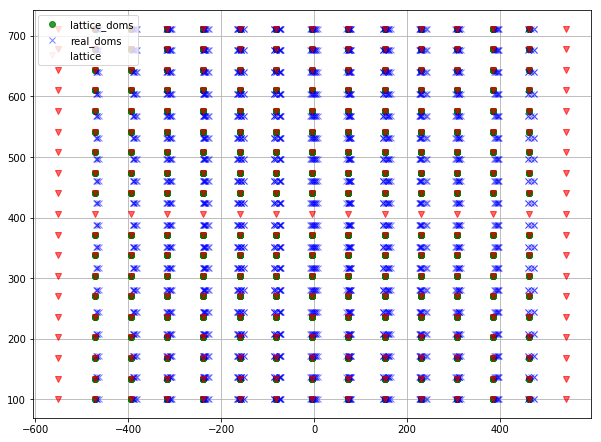

In [156]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,7.5))

#fig = plt.figure(figsize=(15,10))
plt.plot(l_doms['y'], l_doms['z'],"o",  color='green', alpha=0.8, label="lattice_doms")
plt.plot(doms["y"], doms["z"], "x", color="blue", alpha=0.5, label="real_doms")
plt.plot(lattice["y"], lattice["z"], "v", color="red", alpha=0.05, label="lattice")
plt.grid()
plt.legend()
plt.show()
ax.grid()
plt.show()

In [26]:
def deltas(arr1, arr2):
    return((arr2["x"]-arr1["x"], arr2["y"]-arr1["y"], arr2["z"]-arr1["z"]))

for i in range(10):
    print(deltas(doms[i], l_doms[i]))


(9.0, 2.5960043841963616, 0.039161290322340392)
(9.0, 2.5960043841963616, 2.0391612903224541)
(9.0, 2.5960043841963616, 4.0391612903224541)
(9.0, 2.5960043841963616, 6.0391612903224541)
(9.0, 2.5960043841963616, 8.0391612903224541)
(9.0, 2.5960043841963616, 10.039161290322454)
(9.0, 2.5960043841963616, 12.039161290322454)
(9.0, 2.5960043841963616, 14.039161290322454)
(9.0, 2.5960043841963616, 16.039161290322454)
(9.0, 2.5960043841963616, -15.960838709677546)


In [27]:
delta_doms = []
for i in range(doms.size):
    delta_doms.append(deltas(doms[i], l_doms[i]))

In [29]:
dt = np.dtype([('x', np.float64), ('y', np.float64), ('z', np.float64)])
delta_doms = np.asarray(delta_doms, dtype=dt)

In [32]:
delta_doms[0]

( 9.,  2.59600438,  0.03916129)

In [44]:
tslice

array([ 49993098.,  49993248.,  49993398.,  49993548.,  49993698.,
        49993848.,  49993998.,  49994148.,  49994298.,  49994448.,
        49994598.,  49994748.,  49994898.,  49995048.,  49995198.,
        49995348.,  49995498.,  49995648.,  49995798.,  49995948.,
        49996098.,  49996248.,  49996398.,  49996548.,  49996698.,
        49996848.,  49996998.,  49997148.,  49997298.,  49997448.,
        49997598.,  49997748.,  49997898.,  49998048.,  49998198.,
        49998348.,  49998498.,  49998648.,  49998798.,  49998948.,
        49999098.,  49999248.,  49999398.,  49999548.,  49999698.,
        49999848.,  49999998.,  50000148.,  50000298.,  50000448.,
        50000598.,  50000748.,  50000898.,  50001048.,  50001198.,
        50001348.,  50001498.,  50001648.,  50001798.,  50001948.,
        50002098.,  50002248.,  50002398.,  50002548.,  50002698.,
        50002848.,  50002998.,  50003148.,  50003298.,  50003448.,
        50003598.,  50003748.,  50003898.,  50004048.,  500041

In [172]:
timeslice=[]
for i, t in enumerate(tslice):
    timeslice.append((i,t))

In [173]:
timeslice

[(0, 49993098.0),
 (1, 49993248.0),
 (2, 49993398.0),
 (3, 49993548.0),
 (4, 49993698.0),
 (5, 49993848.0),
 (6, 49993998.0),
 (7, 49994148.0),
 (8, 49994298.0),
 (9, 49994448.0),
 (10, 49994598.0),
 (11, 49994748.0),
 (12, 49994898.0),
 (13, 49995048.0),
 (14, 49995198.0),
 (15, 49995348.0),
 (16, 49995498.0),
 (17, 49995648.0),
 (18, 49995798.0),
 (19, 49995948.0),
 (20, 49996098.0),
 (21, 49996248.0),
 (22, 49996398.0),
 (23, 49996548.0),
 (24, 49996698.0),
 (25, 49996848.0),
 (26, 49996998.0),
 (27, 49997148.0),
 (28, 49997298.0),
 (29, 49997448.0),
 (30, 49997598.0),
 (31, 49997748.0),
 (32, 49997898.0),
 (33, 49998048.0),
 (34, 49998198.0),
 (35, 49998348.0),
 (36, 49998498.0),
 (37, 49998648.0),
 (38, 49998798.0),
 (39, 49998948.0),
 (40, 49999098.0),
 (41, 49999248.0),
 (42, 49999398.0),
 (43, 49999548.0),
 (44, 49999698.0),
 (45, 49999848.0),
 (46, 49999998.0),
 (47, 50000148.0),
 (48, 50000298.0),
 (49, 50000448.0),
 (50, 50000598.0),
 (51, 50000748.0),
 (52, 50000898.0),
 (5

In [ ]:
# %load data_preparation
import numpy as np

NFLOORS = 18
NSTRING = 115
PMTSPERDOM = 31
pmtstot = NFLOORS * NSTRING * PMTSPERDOM
ndoms = NFLOORS * NSTRING

#this function creates X with dimension (nevents, timeslice.shape, 2070)
def Xy_creation(timeslices, dom_id, trig, times, flag):
    numu_events = dom_id.shape[0]
    n_timeslices = timeslices.shape[0] - 1

    X_nu = np.zeros((numu_events, n_timeslices, ndoms))

    for evt in range(numu_events):
        # Get all DOM ids for all triggered hits in current event
        triggered_dom_ids = (dom_id[evt][trig[evt] == True]) - 1
        #print("triggered_dom_ids", triggered_dom_ids)
        times_event_hits = times[evt] # select only hits for current event 
        #print("times_event_hits", times_event_hits, times_event_hits.shape[0])
        
        for ts, tslice in enumerate(zip(timeslices[:-1], timeslices[1:])):
            low, high = tslice
            #print(ts, "low", low, "high", high)
            # hits will hold indices of hits matching the condition of being in the selected timeslice
            hits = np.where((times_event_hits >= low) & (times_event_hits < high))[0] 
            #print('hits: ', hits)
            #continue
            if not len(hits):
                continue

            # Get all DOM ids associated to all hits in current time slice.
            dom_hit_in_slice = triggered_dom_ids[hits]
            #print("doms_hit_in_slice", dom_hit_in_slice)
            #print("hits", hits)
            #print(hits.shape)
            # Activate all DOMs for current event, timeslice.
            X_nu[evt, ts, dom_hit_in_slice] = 1
    if flag=='numu':        
        Y_nu = np.ones(dom_id.shape[0])
    elif flag=='nue':
        Y_nu = np.zeros(dom_id.shape[0])
    return X_nu, Y_nu

In [44]:
from scipy import spatial
def lattice_doms(detfile):
    
    from detector_positions import structured_positions
    doms, pmts = structured_positions(detfile)
    
    dt = np.dtype([('x', np.float64), ('y', np.float64), ('z', np.float64)])
    
    #lattice definition (larger than detector)
    xyz = []
    for x in range(-300,1100,90):
        for y in np.arange(-550,550, 45*np.sqrt(3)):
            for i,z in enumerate(range(98,712,36)):
                xyz.append((x,y,z))
            x -=45
    xyz = np.asarray(xyz)
    
    lattice_doms = []
    for pt in doms:
        x,y,z= pt["x"], pt["y"], pt["z"]
        lattice_doms.append((xyz[spatial.KDTree(xyz).query((x,y,z))[1]][0],xyz[spatial.KDTree(xyz).query((x,y,z))[1]][1],xyz[spatial.KDTree(xyz).query((x,y,z))[1]][2]))
                            
    
    lattice_doms_arr = np.asarray(lattice_doms, dtype=dt)
    
    
    xyz = []
    for x in range(-300,1100,90):
        for y in np.arange(-550,550, 45*np.sqrt(3)):
            for i,z in enumerate(range(98,712,36)):
                xyz.append((x,y,z))
            x -=45
    xyz = np.asarray(xyz, dtype=dt) 
    
    return xyz, lattice_doms_arr

In [45]:
lattice, l_doms = lattice_doms(detfile)

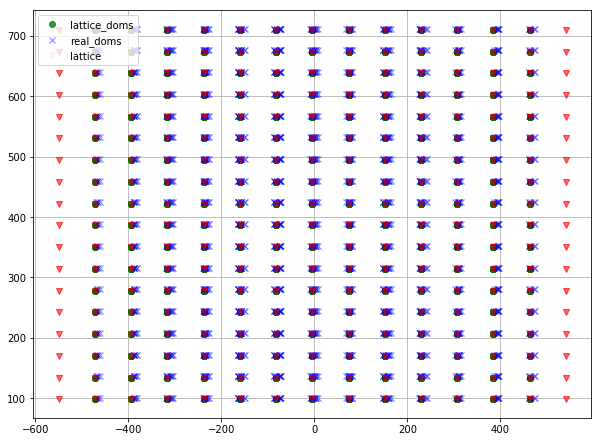

In [46]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,7.5))

#fig = plt.figure(figsize=(15,10))
plt.plot(l_doms['y'], l_doms['z'],"o",  color='green', alpha=0.8, label="lattice_doms")
plt.plot(doms["y"], doms["z"], "x", color="blue", alpha=0.5, label="real_doms")
plt.plot(lattice["y"], lattice["z"], "v", color="red", alpha=0.05, label="lattice")
plt.grid()
plt.legend()
plt.show()
#ax.grid()
plt.show()